In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from itertools import product

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing

In [36]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [37]:
folder = 'D:/Data_Analyst_Projet/Autres cours/Séries temporelles/Analysez+et+modelisez+des+series+temporelles/Analysez et modelisez des series temporelles/1 Datasets/'

In [38]:
beer = pd.read_csv(folder + 'beer.csv', header=None, names=['t', 'beer'], index_col='t', parse_dates=True)
beer.head()

,beer
t,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


# Evolution vente de bière Australie

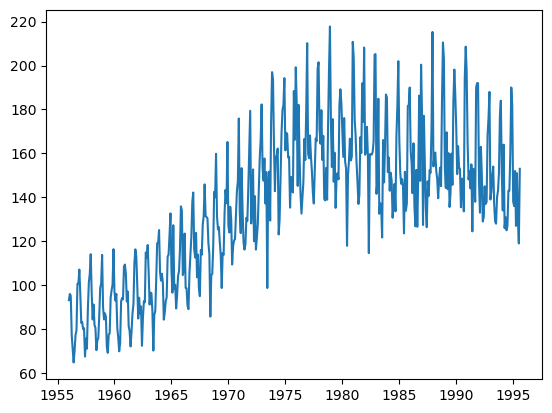

In [39]:
plt.plot(beer['beer'])

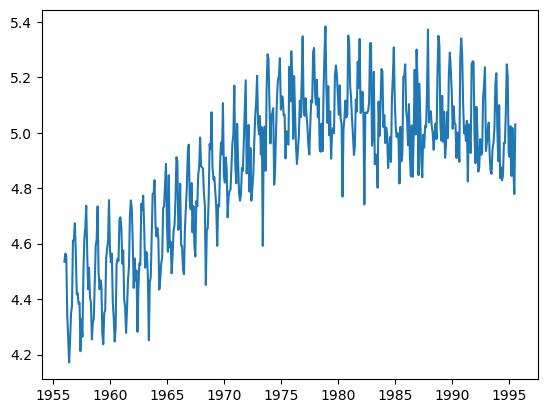

In [40]:
# transformation logarithmique pour rendre la série temporelle additive
y = np.log(beer)
plt.plot(y['beer'])

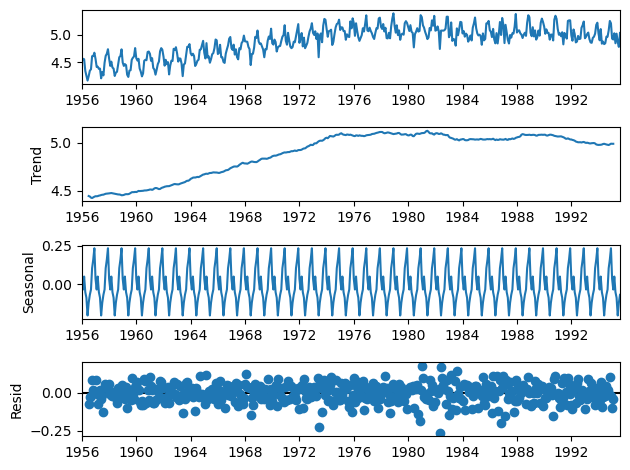

In [41]:
result = seasonal_decompose(y, model='additive')

result.plot()

plt.show()

Tendance à la hausse jusqu'en 1975 environ puis stabilisation.

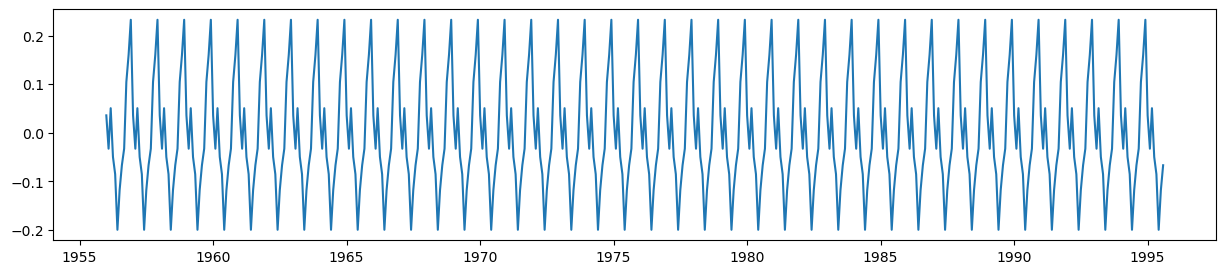

In [42]:
# saisonnalité d'un an
plt.figure(figsize=(15,3))
plt.plot(result.seasonal)
plt.show()

ShapiroResult(statistic=0.9879445433616638, pvalue=0.0007040249765850604)


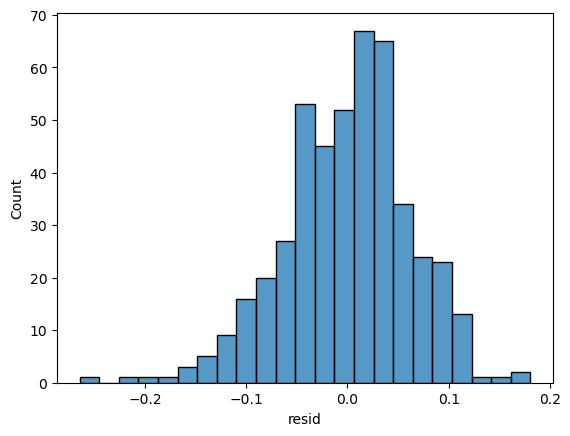

In [43]:
sns.histplot(result.resid.dropna())
print(shapiro(result.resid.dropna()))

# Désaisonnaliser beer avec les moyennes mobiles

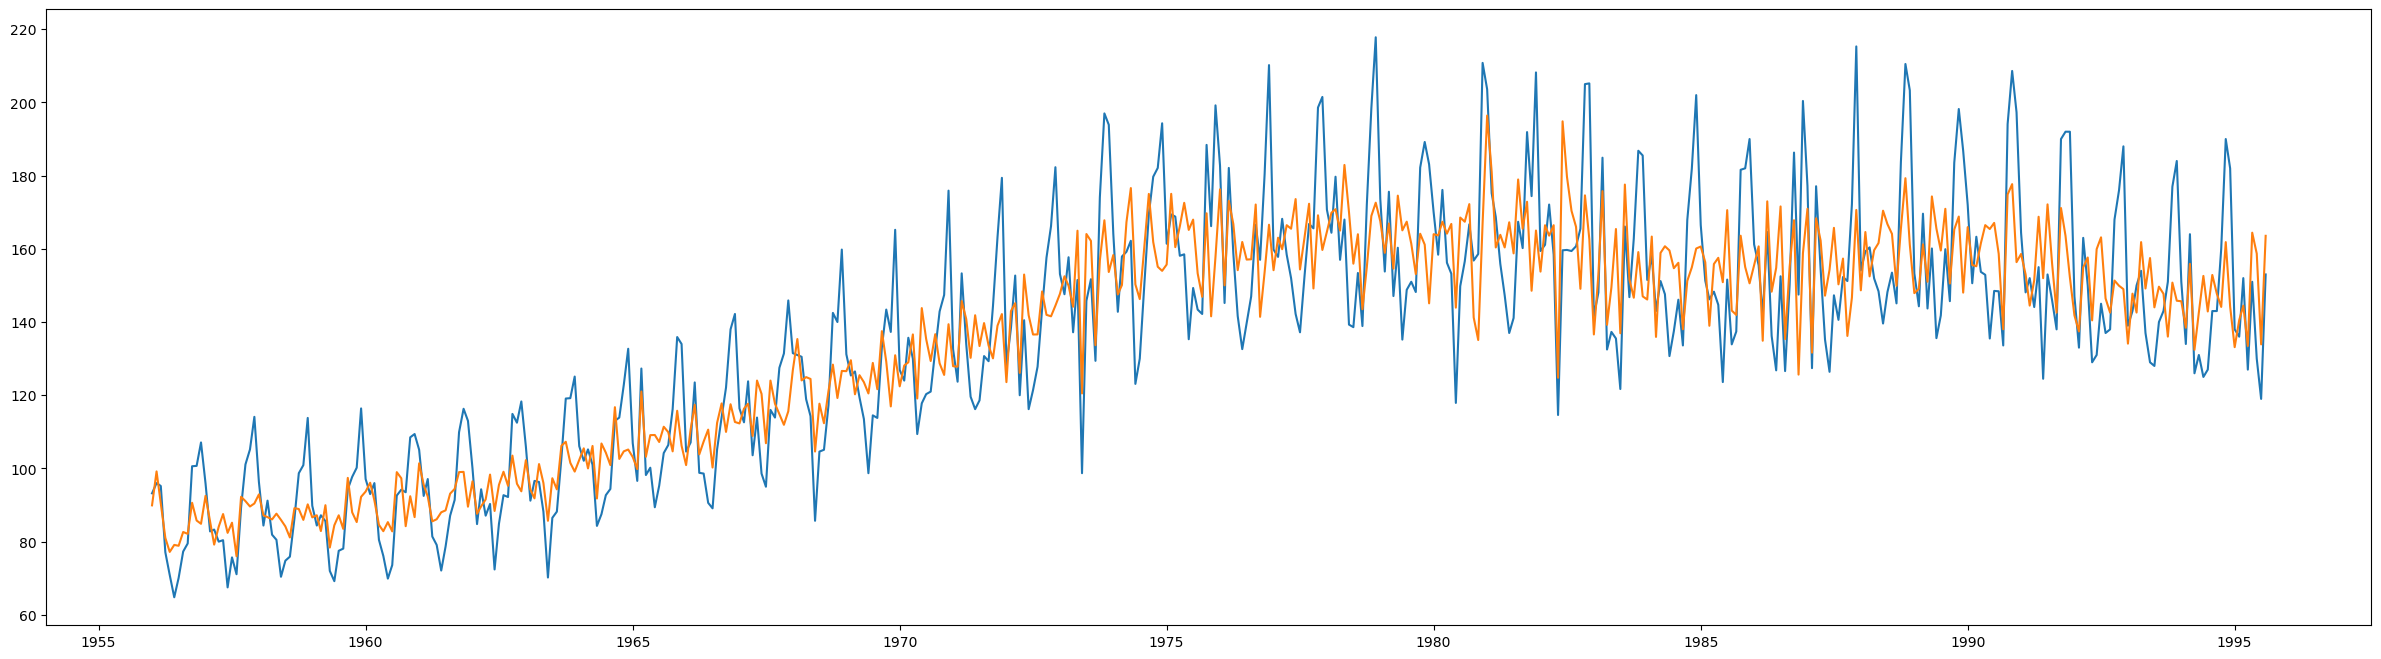

In [44]:
y_cvs = y['beer'] - result.seasonal

plt.figure(figsize=(30,8))

plt.plot(beer['beer'])

plt.plot(np.exp(y_cvs))

plt.show()

# Prédiction avec Lissage exponentielle double

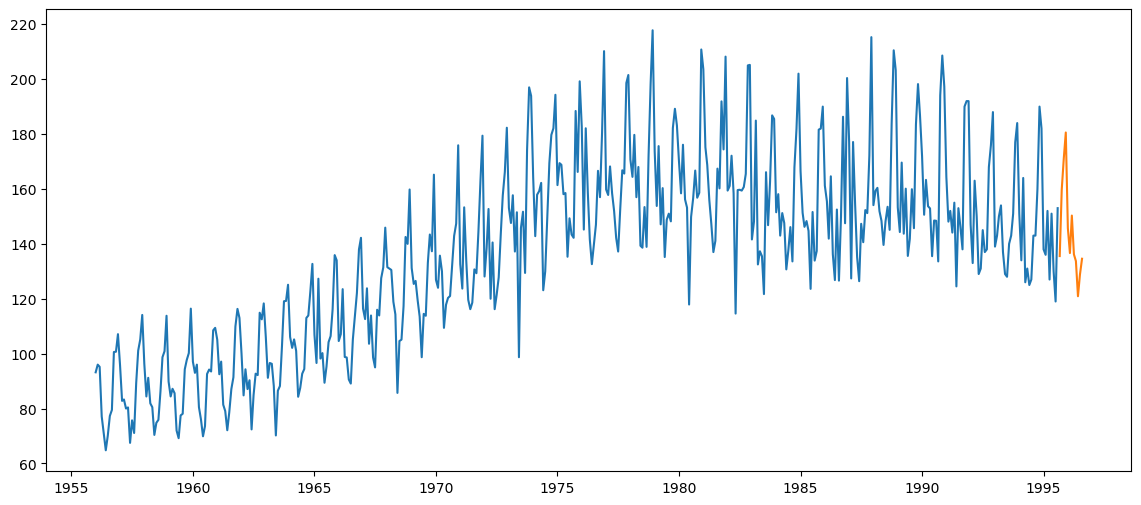

In [45]:
les = ExponentialSmoothing(y['beer'], trend='additive', seasonal='additive', seasonal_periods=12, freq='MS').fit()

les_pred = les.forecast(12)

plt.figure(figsize=(14,6))

plt.plot(beer['beer'], label='beer')

plt.plot(np.exp(les_pred), label='prédictions')

plt.show()

# Modèle SARIMA

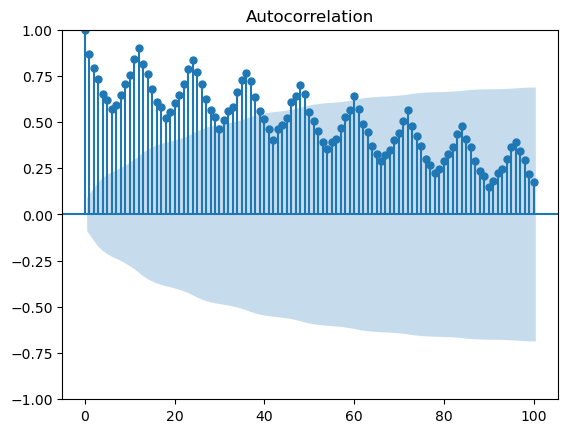

In [46]:
plot_acf(y, lags=100)

plt.show()

La fonction d'autocorrélation décroit lentement vers 0, on visualise aussi la saison.

On procède à une diférenciation en tendance.

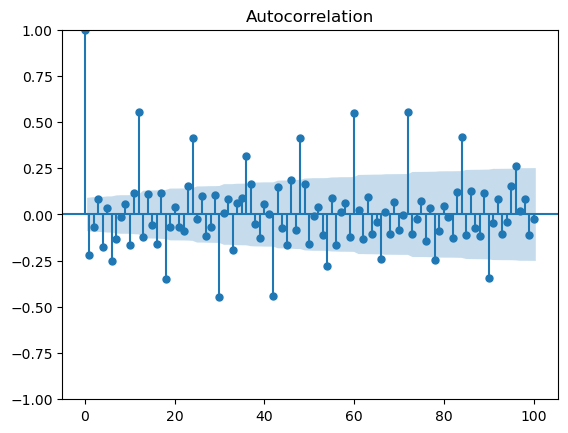

In [47]:
y_dif_1 = (y - y.shift(1)).dropna()

plot_acf(y_dif_1, lags=100)

plt.show()

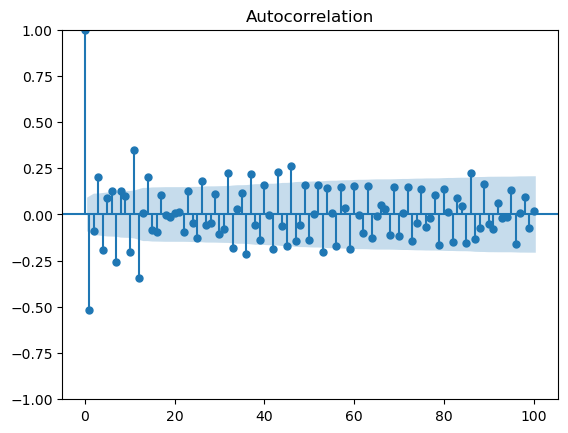

In [48]:
y_dif_1_12 = (y_dif_1 - y_dif_1.shift(12)).dropna()

plot_acf(y_dif_1_12, lags=100)

plt.show()

La fonction d'autocorrélation décroit rapidement vers 0, on a un autocorrélogramme simple.

La série est stationnaire.

In [49]:
def test_stationnaire(series):
    result = adfuller(series)
    print("H0 : La série n'est pas stationnaire",'\n', "H1 : La série est stationnaire")
    print('Statistique du test ADF :', result[0])
    print('Valeur p :', result[1])
    print('Valeurs critiques :', result[4])
    if result[1] < 0.05:
        print('p-value < 0.05, on rejette H0 --> La série temporelle est stationnaire.')
    else:
        print('p-value > 0.05, on ne peut pas rejeter H0 --> La série temporelle n\'est pas stationnaire.')

In [50]:
test_stationnaire(y_dif_1_12)

H0 : La série n'est pas stationnaire 
 H1 : La série est stationnaire
Statistique du test ADF : -8.882698444752318
Valeur p : 1.3049327959648652e-14
Valeurs critiques : {'1%': -3.4450973903602367, '5%': -2.868042229965336, '10%': -2.570233448893}
p-value < 0.05, on rejette H0 --> La série temporelle est stationnaire.


# Identification et choix du modèle

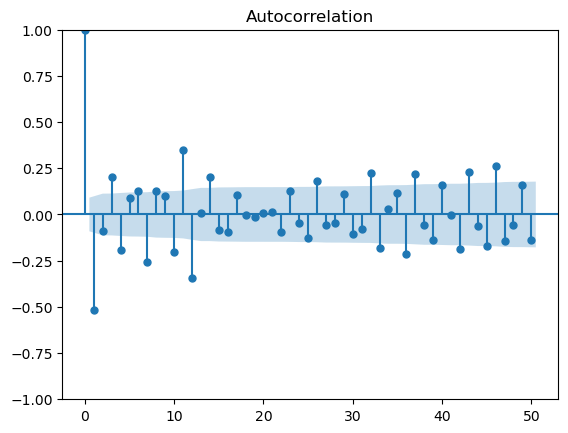

In [51]:
plot_acf(y_dif_1_12, lags=50)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


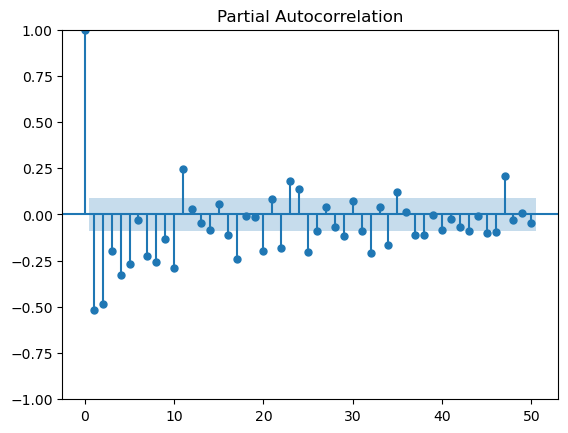

In [52]:
plot_pacf(y_dif_1_12, lags=50)

plt.show()

In [53]:
y[:-1]

,beer
t,
1956-01-01,4.534748
1956-02-01,4.564348
1956-03-01,4.555980
1956-04-01,4.345103
1956-05-01,4.261270
...,...
1995-03-01,5.023881
1995-04-01,4.844187
1995-05-01,5.017280


In [54]:
model1 = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,12), freq='MS')
result1 = model1.fit()
print(result1.summary())

for elt in [6, 12, 18, 24, 30, 36]:
    print(acorr_ljungbox(result1.resid, lags=elt, return_df=False)[1].mean())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               beer   No. Observations:                  476
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 575.760
Date:                            Mon, 12 Feb 2024   AIC                          -1141.520
Time:                                    10:59:06   BIC                          -1120.831
Sample:                                01-01-1956   HQIC                         -1133.376
                                     - 08-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1718      0.042     -4.094      0.000      -0.254      -0.090
ma.L1         -0.8838      0.023   

# Prédiction

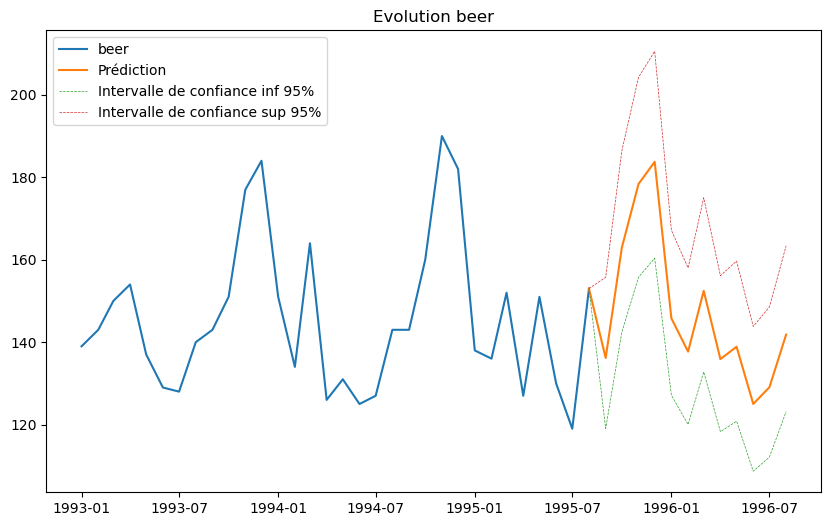

In [55]:
pred_model1 = result1.get_forecast(12)

pred = np.exp(pred_model1.predicted_mean)
pred = pd.concat((beer[-1:].rename(columns={'beer':'predicted_mean'})['predicted_mean'], pred), axis=0)

pred_lower = np.exp(pred_model1.conf_int()['lower beer'])
pred_lower = pd.concat((beer[-1:].rename(columns={'beer':'lower beer'})['lower beer'], pred_lower), axis=0)

pred_upper = np.exp(pred_model1.conf_int()['upper beer'])
pred_upper = pd.concat((beer[-1:].rename(columns={'beer':'upper beer'})['upper beer'], pred_upper), axis=0)

plt.figure(figsize=(10,6))
plt.title("Evolution beer")
plt.plot(beer['beer']['1993':], label='beer')
plt.plot(pred, label='Prédiction')
plt.plot(pred_lower, linestyle='--', lw=0.5, label='Intervalle de confiance inf 95%')
plt.plot(pred_upper, linestyle='--', lw=0.5, label='Intervalle de confiance sup 95%')
plt.legend()
plt.show()

# Analyse à posteriori

<Axes: xlabel='t'>

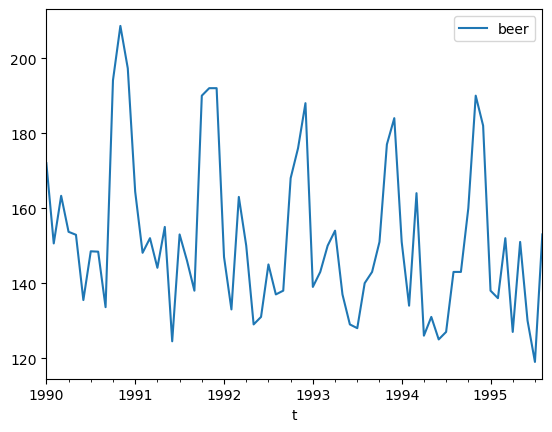

In [56]:
beer['1990':].plot()

In [57]:
train = y[:'1993']
test = beer['1994':]

In [58]:
model2 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12), freq='MS')
result2 = model2.fit()
print(result2.summary())

for elt in [6, 12, 18, 24, 30, 36]:
    print(acorr_ljungbox(result2.resid, lags=elt, return_df=False)[1].mean())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               beer   No. Observations:                  456
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 550.346
Date:                            Mon, 12 Feb 2024   AIC                          -1090.692
Time:                                    10:59:08   BIC                          -1070.225
Sample:                                01-01-1956   HQIC                         -1082.620
                                     - 12-01-1993                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1645      0.043     -3.849      0.000      -0.248      -0.081
ma.L1         -0.8821      0.023   

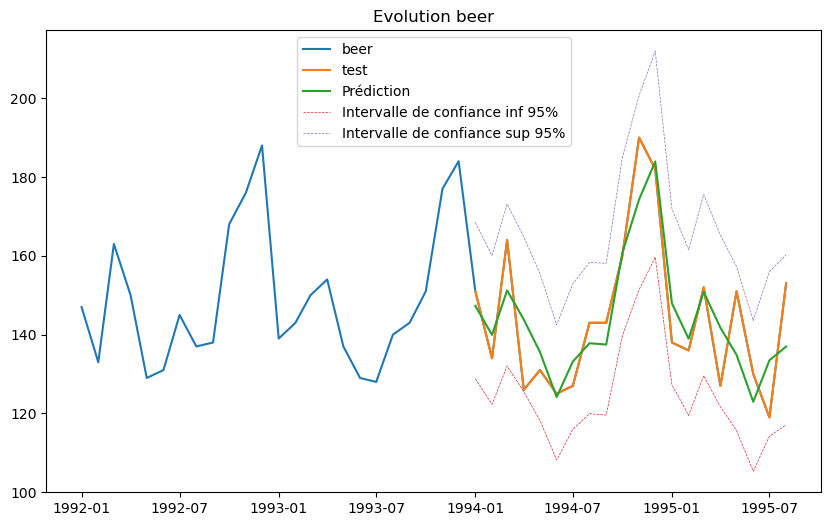

In [59]:
pred_model2 = result2.get_forecast(20)

pred = np.exp(pred_model2.predicted_mean)

pred_lower = np.exp(pred_model2.conf_int()['lower beer'])

pred_upper = np.exp(pred_model2.conf_int()['upper beer'])

plt.figure(figsize=(10,6))
plt.title("Evolution beer")
plt.plot(beer['beer']['1992':], label='beer')
plt.plot(test, label='test')
plt.plot(pred, label='Prédiction')
plt.plot(pred_lower, linestyle='--', lw=0.5, label='Intervalle de confiance inf 95%')
plt.plot(pred_upper, linestyle='--', lw=0.5, label='Intervalle de confiance sup 95%')
plt.legend()
plt.show()

In [60]:
test = test['beer']

In [61]:
# erreur relative absolu moyenne en %
mape = 100*(np.sum(np.abs((test - pred)/test)))/len(test)
mape

5.783022693304359

In [62]:
# erreur quadratique moyenne
rmse = np.sqrt(np.sum((test - pred)**2)/len(test))
rmse

10.00450406915532

In [63]:
test

t
1994-01-01    151.0
1994-02-01    134.0
1994-03-01    164.0
1994-04-01    126.0
1994-05-01    131.0
1994-06-01    125.0
1994-07-01    127.0
1994-08-01    143.0
1994-09-01    143.0
1994-10-01    160.0
1994-11-01    190.0
1994-12-01    182.0
1995-01-01    138.0
1995-02-01    136.0
1995-03-01    152.0
1995-04-01    127.0
1995-05-01    151.0
1995-06-01    130.0
1995-07-01    119.0
1995-08-01    153.0
Name: beer, dtype: float64

# Comparaison de modèle

In [65]:
from tqdm import tqdm

In [66]:
scores = {'params' : [],
         'rmse' : [],
         'mape' : [],
         'params_non_signigicatif' : [],
         'test_blancheur_non_passe' : [],
         'aic' : [],
         'bic' : []}

for a,b,c,d in tqdm(product([0,1], repeat=4)):
    
    train = y[:'1993']['beer']
    test = beer['1994':]['beer']
    
    model = SARIMAX(train, order=(a,1,b), seasonal_order=(c,1,d,12), freq='MS')
    result = model.fit()
    #print(f"Modèle : order=({a},1,{b}), seasonal_order=({c},1,{d},12)")
    #print(result.summary())
        
    pred_model = result.get_forecast(20)

    pred = np.exp(pred_model.predicted_mean)

    pred_lower = np.exp(pred_model.conf_int()['lower beer'])

    pred_upper = np.exp(pred_model.conf_int()['upper beer'])

    '''
    plt.figure(figsize=(15,6))
    plt.title("Evolution beer")
    plt.plot(beer['beer']['1992':], label='train')
    plt.plot(test, label='test')
    plt.plot(pred, label='Prédiction')
    plt.legend()
    plt.show()
    '''
    
    tests_blancheur = []
    for elt in [6, 12, 18, 24, 30, 36]:
        test_blancheur = acorr_ljungbox(result.resid, lags=elt, return_df=False)[1].mean()
        if test_blancheur < 0.05 : tests_blancheur.append(test_blancheur) 
            
    scores['test_blancheur_non_passe'].append(len(tests_blancheur))
    
    params = (a,1,b,c,1,d,12)
    rmse = mean_squared_error(test.values, pred.values)
    mape = mean_absolute_percentage_error(test.values, pred.values)
    params_non_significatif = len(result.pvalues[result.pvalues>0.05].values)
    
    scores['params'].append(params)
    scores['rmse'].append(rmse)
    scores['mape'].append(mape)
    scores['params_non_signigicatif'].append(params_non_significatif)
    scores['aic'].append(result.aic)
    scores['bic'].append(result.bic)

pd.DataFrame(scores)

0it [00:00, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
1it [00:00,  3.77it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
2it [00:01,  1.70it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
3it [00:01,  1.74it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model

,params,rmse,mape,params_non_signigicatif,test_blancheur_non_passe,aic,bic
0,"(0, 1, 0, 0, 1, 0, 12)",148.785495,0.066137,0,0,-567.661839,-563.568270
1,"(0, 1, 0, 0, 1, 1, 12)",96.575047,0.058259,0,0,-766.224017,-758.036878
2,"(0, 1, 0, 1, 1, 0, 12)",138.931426,0.063199,0,0,-621.102823,-612.915683
3,"(0, 1, 0, 1, 1, 1, 12)",98.108926,0.058143,0,0,-772.999419,-760.718709
4,"(0, 1, 1, 0, 1, 0, 12)",142.122384,0.064439,0,0,-922.197413,-914.010273
5,"(0, 1, 1, 0, 1, 1, 12)",99.757097,0.058843,0,0,-1075.105121,-1062.824412
6,"(0, 1, 1, 1, 1, 0, 12)",141.333731,0.063909,0,0,-971.590182,-959.309473
7,"(0, 1, 1, 1, 1, 1, 12)",99.822761,0.058121,0,0,-1082.135250,-1065.760971
8,"(1, 1, 0, 0, 1, 0, 12)",136.844676,0.062414,0,0,-701.725094,-693.537955
9,"(1, 1, 0, 0, 1, 1, 12)",97.470219,0.058530,0,0,-895.800831,-883.520121


In [67]:
score = pd.DataFrame(scores)
score.sort_values('rmse')

,params,rmse,mape,params_non_signigicatif,test_blancheur_non_passe,aic,bic
1,"(0, 1, 0, 0, 1, 1, 12)",96.575047,0.058259,0,0,-766.224017,-758.036878
9,"(1, 1, 0, 0, 1, 1, 12)",97.470219,0.058530,0,0,-895.800831,-883.520121
11,"(1, 1, 0, 1, 1, 1, 12)",97.999447,0.058480,0,0,-901.105110,-884.730831
3,"(0, 1, 0, 1, 1, 1, 12)",98.108926,0.058143,0,0,-772.999419,-760.718709
5,"(0, 1, 1, 0, 1, 1, 12)",99.757097,0.058843,0,0,-1075.105121,-1062.824412
7,"(0, 1, 1, 1, 1, 1, 12)",99.822761,0.058121,0,0,-1082.135250,-1065.760971
15,"(1, 1, 1, 1, 1, 1, 12)",100.090102,0.057830,0,0,-1090.692485,-1070.224636
13,"(1, 1, 1, 0, 1, 1, 12)",100.973531,0.058566,0,0,-1084.835995,-1068.461716
10,"(1, 1, 0, 1, 1, 0, 12)",136.720454,0.062501,0,0,-756.935607,-744.654898
8,"(1, 1, 0, 0, 1, 0, 12)",136.844676,0.062414,0,0,-701.725094,-693.537955
